<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/cDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


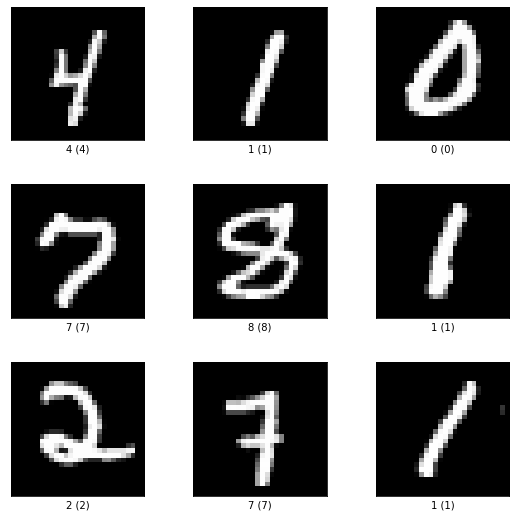

In [2]:
ds_train, ds_info = tfds.load('mnist', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_info, ds_train)

In [3]:
batch_size = 400
global_batch_size = batch_size *  1
image_shape = (32, 32, 1)

def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])    
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    label = features['label']
    return image, label


ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(global_batch_size)

train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

150


In [4]:
def conv_block(channels, kernels,
               strides=1, padding='same',
               bn=True, activation=True):
    model = tf.keras.Sequential()
        
    model.add(layers.Conv2D(channels, kernels, strides=strides, padding=padding))
    if bn:
        model.add(layers.BatchNormalization())              
    if activation:
        model.add(layers.LeakyReLU(0.2)) 
                  
    return model

In [5]:
def build_generator(num_classes, z_dim):

    DIM = 64

    input_label = layers.Input(shape=1, dtype=tf.int32, name="Class Label")

    one_hot_label = tf.one_hot(input_label, num_classes)
    one_hot_label = layers.Reshape((num_classes,))(one_hot_label)

    input_z = layers.Input(shape=z_dim, name='LatentVector')
    x = layers.Concatenate()([input_z, one_hot_label])

    x = layers.Dense(4*4*4*DIM, activation=None)(x)
    x = layers.Reshape((4,4,4*DIM))(x)

    x = layers.UpSampling2D((2,2), interpolation="bilinear")(x)
    x = conv_block(2*DIM, 5)(x)

    x = layers.UpSampling2D((2,2), interpolation="bilinear")(x)
    x = conv_block(DIM, 5)(x)

    x = layers.UpSampling2D((2,2), interpolation="bilinear")(x)
    output = layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh')(x)

    return Model(inputs=[input_z, input_label], outputs=output)

In [6]:
def build_discriminator(num_classes, input_shape):
    DIM = 64
        
    # label
    input_label = layers.Input(shape=[1], dtype =tf.int32, name='Class Label')
    encoded_label = tf.one_hot(input_label, num_classes)
    embedding = layers.Dense(32 * 32 * 1, activation=None)(encoded_label)
    embedding = layers.Reshape((32, 32, 1))(embedding)
        
    # discriminator
    input_image = layers.Input(shape=input_shape, name='Image')
    x = layers.Concatenate()([input_image, embedding])
    x = conv_block(DIM, 5, 2, bn=False)(x)
    x = conv_block(2*DIM, 5, 2)(x)
    x = conv_block(4*DIM, 5, 2)(x)
    x = layers.Flatten()(x)

    output = layers.Dense(1, activation='sigmoid')(x)
    return Model(inputs=[input_image, input_label], outputs=output) 

In [7]:
class cDCGAN(Model):

    def __init__(self, z_dim, image_shape):
        super(cDCGAN, self).__init__()

        self.z_dim = z_dim
        self.image_shape = image_shape
        self.num_classes = 10

        self.n_discriminator = 1

        self.discriminator = build_discriminator(self.num_classes, image_shape)
        self.generator = build_generator(self.num_classes, z_dim)

    
    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn):
        super(cDCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn

    def train_step(self, inputs):
        real_imgs, labels = inputs

        batch_size = tf.shape(labels)[0]

        real_lbs = tf.ones(batch_size)
        fake_lbs = tf.zeros(batch_size)

        z = tf.random.normal((batch_size, self.z_dim))

        fake_labels = tf.random.uniform((batch_size, 1), minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as g_tape, \
            tf.GradientTape() as d_tape:

            fake_imgs = self.generator([z, fake_labels])

            real_preds = self.discriminator([real_imgs, labels])
            fake_preds = self.discriminator([fake_imgs, fake_labels])

            d_loss = 0.5 * (self.d_loss_fn(real_lbs, real_preds) + self.d_loss_fn(fake_lbs, fake_preds))

            g_loss = self.g_loss_fn(real_lbs, fake_preds)
        
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)

        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {'g_loss': g_loss, 'd_loss': d_loss}
    
    def call(self, num_imgs, number=None):
        z = tf.random.normal((num_imgs, self.z_dim))
        if number:
            number = tf.one_hot(number, self.num_classes)
            number = tf.repeat(number, num_imgs)
        else:
            number = tf.random.uniform((num_imgs,), minval=0, maxval=self.num_classes, dtype=tf.int32)
        return self.generator([z, number])

In [8]:
class GenerativeCallback(tf.keras.callbacks.Callback):

    def __init__(self, num_imgs=5, interval=5):
        super(GenerativeCallback, self).__init__()
        
        self.num_imgs = num_imgs
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch % self.interval) is not 0:
            return 
        grid_row = 1
        grid_col = self.num_imgs
        images = self.model(self.num_imgs)
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col,:,:,0]+1)*127.5, cmap='gray')
            axarr[col].axis('off') 
        plt.show()

Epoch 1/30
150/150 [==============================] - 40s 185ms/step - g_loss: 1.3564 - d_loss: 0.3425


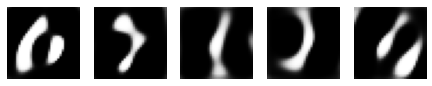

Epoch 2/30
150/150 [==============================] - 29s 196ms/step - g_loss: 1.6459 - d_loss: 0.3905
Epoch 3/30
150/150 [==============================] - 28s 189ms/step - g_loss: 1.3557 - d_loss: 0.4611
Epoch 4/30
150/150 [==============================] - 28s 187ms/step - g_loss: 1.1302 - d_loss: 0.5138


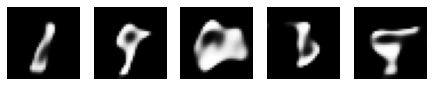

Epoch 5/30
150/150 [==============================] - 29s 192ms/step - g_loss: 1.0296 - d_loss: 0.5539
Epoch 6/30
150/150 [==============================] - 29s 190ms/step - g_loss: 1.0239 - d_loss: 0.5446
Epoch 7/30
150/150 [==============================] - 29s 190ms/step - g_loss: 1.1040 - d_loss: 0.5129


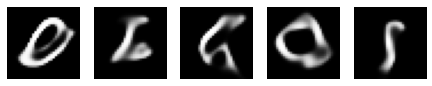

Epoch 8/30
150/150 [==============================] - 29s 196ms/step - g_loss: 1.1807 - d_loss: 0.4894
Epoch 9/30
150/150 [==============================] - 28s 188ms/step - g_loss: 1.2017 - d_loss: 0.4914
Epoch 10/30
150/150 [==============================] - 30s 197ms/step - g_loss: 1.1904 - d_loss: 0.5008


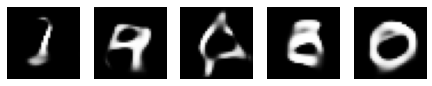

Epoch 11/30
150/150 [==============================] - 28s 189ms/step - g_loss: 1.1962 - d_loss: 0.4999
Epoch 12/30
150/150 [==============================] - 29s 194ms/step - g_loss: 1.2073 - d_loss: 0.4975
Epoch 13/30
150/150 [==============================] - 28s 189ms/step - g_loss: 1.2096 - d_loss: 0.5017


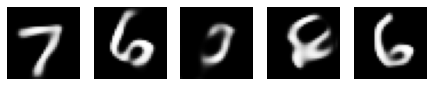

Epoch 14/30
150/150 [==============================] - 29s 192ms/step - g_loss: 1.1967 - d_loss: 0.5058
Epoch 15/30
150/150 [==============================] - 29s 195ms/step - g_loss: 1.1876 - d_loss: 0.5108
Epoch 16/30
150/150 [==============================] - 28s 189ms/step - g_loss: 1.1789 - d_loss: 0.5150


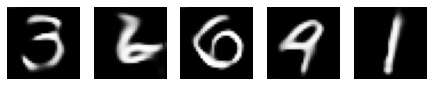

Epoch 17/30
150/150 [==============================] - 29s 192ms/step - g_loss: 1.1645 - d_loss: 0.5142
Epoch 18/30
150/150 [==============================] - 29s 196ms/step - g_loss: 1.1813 - d_loss: 0.5086
Epoch 19/30
150/150 [==============================] - 29s 192ms/step - g_loss: 1.1784 - d_loss: 0.5137


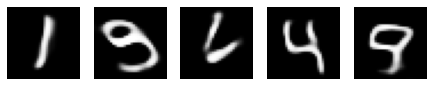

Epoch 20/30
150/150 [==============================] - 29s 190ms/step - g_loss: 1.1808 - d_loss: 0.5138
Epoch 21/30
150/150 [==============================] - 30s 199ms/step - g_loss: 1.1938 - d_loss: 0.5115
Epoch 22/30
150/150 [==============================] - 28s 189ms/step - g_loss: 1.1925 - d_loss: 0.5052


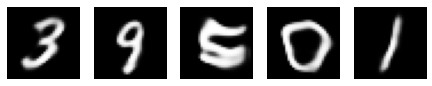

Epoch 23/30
150/150 [==============================] - 30s 197ms/step - g_loss: 1.2124 - d_loss: 0.5065
Epoch 24/30
150/150 [==============================] - 29s 191ms/step - g_loss: 1.2145 - d_loss: 0.5007
Epoch 25/30
150/150 [==============================] - 29s 195ms/step - g_loss: 1.2409 - d_loss: 0.5002


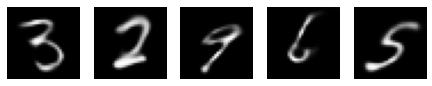

Epoch 26/30
150/150 [==============================] - 29s 190ms/step - g_loss: 1.2378 - d_loss: 0.4917
Epoch 27/30
150/150 [==============================] - 30s 198ms/step - g_loss: 1.2596 - d_loss: 0.4937
Epoch 28/30
150/150 [==============================] - 29s 191ms/step - g_loss: 1.2556 - d_loss: 0.4878


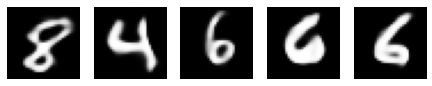

Epoch 29/30
150/150 [==============================] - 29s 195ms/step - g_loss: 1.2757 - d_loss: 0.4799
Epoch 30/30
150/150 [==============================] - 29s 194ms/step - g_loss: 1.3193 - d_loss: 0.4726


In [9]:
cdcgan = cDCGAN(100, image_shape)

cdcgan.compile(RMSprop(1e-4), RMSprop(1e-4), BinaryCrossentropy(), BinaryCrossentropy())

cdcgan.fit(ds_train, epochs=30, callbacks=[GenerativeCallback(interval=3)])

In [10]:
def plot_images(images):   
        grid_row = 1
        grid_col = 10
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col,:,:,0]+1)*127.5, cmap='gray')
            axarr[col].axis('off') 
        plt.show()

In [11]:
def sample_images(class_labels):
        z = tf.random.normal((len(class_labels), 100))
        images = cdcgan.generator.predict([z,class_labels])
        plot_images(images)
        return images

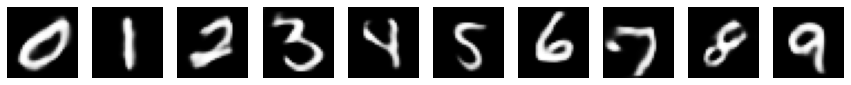

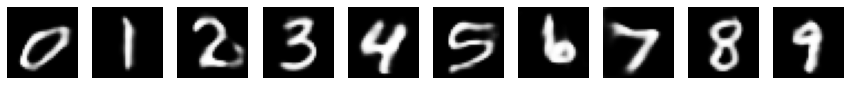

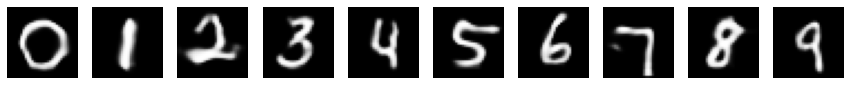

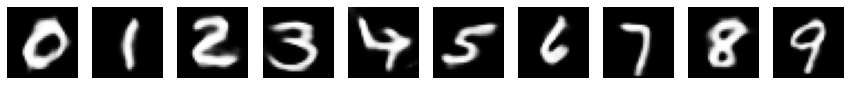

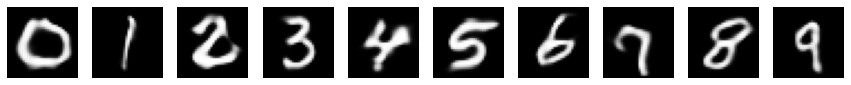

In [13]:
for i in range(5):
    images = sample_images(np.array([0,1,2,3,4,5,6,7,8,9]))